In [59]:
import Pkg
Pkg.add("DifferentialEquations")
Pkg.add("Distributions")
Pkg.add("Polynomials")
print(VERSION)

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...


1.4.1

   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


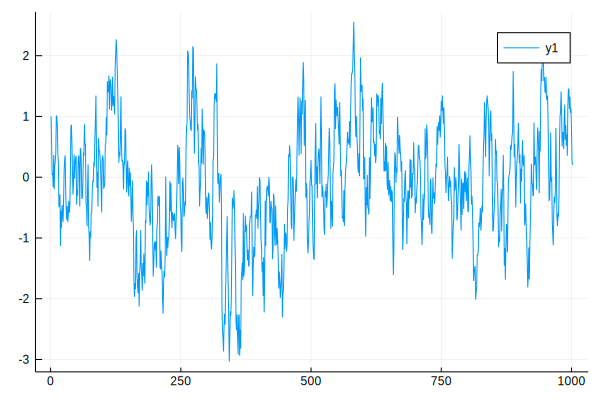

In [179]:
using DifferentialEquations
using Plots

μ = 0.0
σ = sqrt(2)
Θ = 1.0
W = OrnsteinUhlenbeckProcess(Θ,μ,σ,0.0,1.0)
prob = NoiseProblem(W,(0.0,100.0))
sol = solve(prob;dt=0.1)
plot(sol.u)

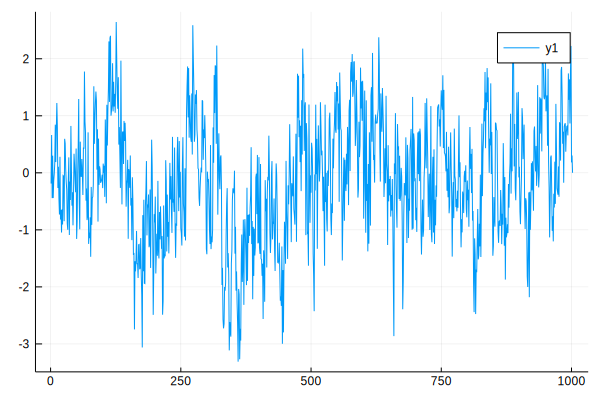

In [180]:
using Distributions, Random
ou_data = sol.u
noise = rand(Normal(0,0.5), length(ou_data))
data = ou_data.+noise
plot(data)

In [62]:
using Polynomials
# function to calculate A and B from the dataset
function OUanalytic(data)
    N = length(data)
    data1sq = data[1]^2
    dataNsq = data[end]^2
    datasq = sum(data[2:end-1].^2)
    datacorr = sum(data[1:end-1].*data[2:end])
    B_coef = Poly([N*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       (2.0-N)*datacorr,     
       (N-1)*datasq])
    B=roots(B_coef)[end-1]
    Q=(data1sq+dataNsq)/(1-B^2)
    Q=Q+datasq*(1+B^2)/(1-B^2)
    Q=Q-datacorr*2*B/(1-B^2)
    A = Q/N
    P2A = -N/A^2/2
    Btmp = B^2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B^4*(N-1))*datasq - 2*B*(1+B^2+2*N)*datacorr
    P2B = -tmp/((1-B^2)^2*(data1sq+dataNsq + (1+B^2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B^2)
    dA = sqrt(-P2B/(P2A*P2B-PAB^2))
    dB = sqrt(-P2A/(P2A*P2B-PAB^2))
    return A,dA,B,dB
end

function OUresult(data,deltat)
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/log(B)
    dtau = deltat*dB/B/log(B)^2
    return A,dA,tau,dtau
end

OUresult (generic function with 1 method)

In [63]:
OUanalytic(ou_data)

(0.7463158839472863, 0.09560871774246789, 0.8859807629800794, 0.01458512794609389)

In [88]:
using Polynomials
# function to calculate A and B from the dataset
function OUEM(data1sq,dataNsq,datasq,datacorr,N)
    B_coef = Poly([N*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       (2.0-N)*datacorr,     
       (N-1)*datasq])
    B=roots(B_coef)[end-1]
    Q=(data1sq+dataNsq)/(1-B^2)
    Q=Q+datasq*(1+B^2)/(1-B^2)
    Q=Q-datacorr*2*B/(1-B^2)
    A = Q/N
    P2A = -N/A^2/2
    Btmp = B^2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B^4*(N-1))*datasq - 2*B*(1+B^2+2*N)*datacorr
    P2B = -tmp/((1-B^2)^2*(data1sq+dataNsq + (1+B^2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B^2)
    dA = sqrt(-P2B/(P2A*P2B-PAB^2))
    dB = sqrt(-P2A/(P2A*P2B-PAB^2))
    return A,dA,B,dB
end

function OUEMresult(data1sq,dataNsq,datasq,datacorr,N,deltat)
    A, dA, B ,dB = OUEM(data1sq,dataNsq,datasq,datacorr,N)
    tau = -deltat/log(B)
    dtau = deltat*dB/B/log(B)^2
    return A,dA,tau,dtau
end

OUEMresult (generic function with 1 method)

In [176]:
# function to multiply two Gaussians
function mul_gauss(mu1,mu2,sigma1,sigma2)
    mu = (mu1*sigma2^2+mu2*sigma1^2)/(sigma1^2+sigma2^2)
    sigma = sqrt(sigma1^2*sigma2^2/(sigma1^2+sigma2^2))
    return mu,sigma
end

# function to convolute two Gaussians
function con_gauss(mu1,mu2,sigma1,sigma2)
    mu = mu1 + mu2
    sigma = sqrt(sigma1^2+sigma2^2)
    return mu,sigma
end

# function to calculate helper function alpha (forward)
function alpha(y,sigmaN,A,B)
    N = length(y)
    sig_alpha = zeros(N)
    mu_alpha = zeros(N)
    mu_alpha[1],sig_alpha[1] = mul_gauss(0,y[1],sqrt(A),sigmaN)
    for i=2:N
        mu_temp,sig_temp = con_gauss(B*mu_alpha[i-1],0,B*sig_alpha[i-1],sqrt(A*(1-B^2)))
        mu_alpha[i],sig_alpha[i] = mul_gauss(mu_temp,y[i],sig_temp,sigmaN)
    end
    return mu_alpha,sig_alpha
end

function beta(y,sigmaN,A,B)
    N = length(y)
    sig_beta = zeros(N-1)
    mu_beta  = zeros(N-1)
    mu_beta[N-1],sig_beta[N-1] = y[N]/B,sqrt(sigmaN^2+A*(1-B^2))/B
    for i=(N-2):-1:1
        mu_temp,sig_temp = mul_gauss(mu_beta[i+1],y[i+1],sig_beta[i+1],sigmaN)
        mu_beta[i],sig_beta[i] = mu_temp/B,sqrt(sig_temp^2+A*(1-B^2))/B
    end
    return mu_beta,sig_beta
end

function px(y,sigmaN,A,B)
    N = length(y)
    mu_px = zeros(N)
    sig_px = zeros(N)
    exxpone = zeros(N-1)
    rho = zeros(N-1)
    mu_x = zeros(N-1)
    mu_xpone = zeros(N-1)
    mu_alpha,sig_alpha = alpha(y,sigmaN,A,B)
    mu_beta,sig_beta = beta(y,sigmaN,A,B)
    for i=1:N-1
        mu_px[i],sig_px[i] = mul_gauss(mu_alpha[i],mu_beta[i],sig_alpha[i],sig_beta[i])
        if i==N-1
            mu_tmp,sig_tmp = y[N],sigmaN
        else
            mu_tmp,sig_tmp = mul_gauss(mu_beta[i+1],y[i+1],sig_beta[i+1],sigmaN)
        end
        # these are the polynomial coefficients of the distribution
        a = 1.0/(2*sig_tmp)+1.0/(2*(A*(1-B^2)))
        b = 1.0/(2*sig_alpha[i])+B^2/(2*(A*(1-B^2)))
        c = -B/(A*(1-B^2))
        d = -mu_tmp/sig_tmp^2
        e = -mu_alpha[i]/sig_alpha[i]^2
        rho[i] = -c/(2*sqrt(a*b))
        exxpone[i] = -c/(4*a*b-c^2)
        mu_xpone[i] = (2*b*d+c*e)/(4*a*b-c^2)
        mu_x[i] = (2*a*e+d*c)/(4*a*b-c^2)
    end
    # for last one beta = 1
    mu_px[N] = mu_alpha[N]
    sig_px[N] = sig_alpha[N]
    # it seems that the sign of mu_x and mu_xpone are not accuaratly determined by this method
    # we need to correct the signs.  We chose the sign so that mu_x[i] is closest to mu_px[i]
    # and mu_xpone[i] is closeset to mu_px[i+1]
     nswitch=0
    for i=1:N-1
        dx1 = abs(mu_x[i]-mu_px[i])
        dx2 = abs(-mu_x[i]-mu_px[i])
        dxp1 = abs(mu_xpone[i]-mu_px[i+1])
        dxp2 = abs(-mu_xpone[i]-mu_px[i+1])
        if dx1>dx2
            nswitch = nswitch+1
            mu_x[i] = -mu_x[i]
        end
        if dxp1>dxp2
            nswitch = nswitch+1
            mu_xpone[i] = -mu_xpone[i]
        end
    end
    return mu_px,sig_px,rho,exxpone,mu_x,mu_xpone,nswitch
end

px (generic function with 1 method)

In [177]:
mu_px,sig_px,rho,exxpone,mu_x,mu_xpone,nswitch = px(data,sigmaN,A,B)
println(nswitch)

1585


In [181]:
sigmaN = 0.5
A=1.0
B=0.9
N=length(data)
println("A: ",A,"  B: ",B,"  SigmaN: ",sigmaN)
for i=1:200
    mu_px,sig_px,rho,exxpone,mu_x,mu_xpone,nswitch = px(data,sigmaN,A,B)
    # lets calculate all the values that we need for OU analysis
    # data1sq,dataNsq,datasq,datacorr
    data1sq = sig_px[1]^2 + mu_px[1]^2
    dataNsq = sig_px[end]^2 + mu_px[end]^2
    datasq = sum(sig_px[2:end-1].^2 .+ mu_px[2:end-1].^2)
    datacorr = sum(exxpone)+abs(sum(mu_x.*mu_xpone))
#    println(data1sq)
#    println(dataNsq)
#    println(datasq)
#    println(datacorr)
    A,dA,B,dB=OUEM(data1sq,dataNsq,datasq,datacorr,N)
    sigmaN = sqrt(1/length(data)*sum(sig_px.^2+mu_px.^2+data.^2-2*mu_px.*data))
    println("A: ",A,"  B: ",B,"  SigmaN: ",sigmaN," nswitch: ",nswitch)
end

A: 1.0  B: 0.9  SigmaN: 0.5
A: 0.8970316811467863  B: 0.6509936781784852  SigmaN: 0.5118389224572972 nswitch: 1457
A: 1.0017334014354224  B: 0.6921158944689149  SigmaN: 0.4803194988110037 nswitch: 1719
A: 1.023724948198659  B: 0.7597814048338651  SigmaN: 0.4564688701548636 nswitch: 1720
A: 1.0102614096075166  B: 0.7275788403433958  SigmaN: 0.44388656611650895 nswitch: 1678
A: 1.021561197838688  B: 0.8175173434916435  SigmaN: 0.4306470095615886 nswitch: 1710
A: 0.9862838571345777  B: 0.7014493449687434  SigmaN: 0.43435392869833916 nswitch: 1635
A: 1.0238299819961802  B: 0.8999219819606892  SigmaN: 0.42114451204423664 nswitch: 1726
A: 0.9183788130722881  B: 0.7221680624411115  SigmaN: 0.45909921250667846 nswitch: 1506
A: 1.0031991235072897  B: 0.7353255436695524  SigmaN: 0.44468389767093114 nswitch: 1692
A: 1.0179122280480744  B: 0.793385544993961  SigmaN: 0.43229254276866363 nswitch: 1701
A: 0.9987102529965404  B: 0.7380588549352453  SigmaN: 0.430564813699429 nswitch: 1661
A: 1.01823737

A: 0.9184755746880308  B: 0.7114055587587581  SigmaN: 0.46191278473548925 nswitch: 1505
A: 1.005628370049725  B: 0.7455689509927015  SigmaN: 0.44579955398272786 nswitch: 1699
A: 1.014681653795724  B: 0.7692849405920631  SigmaN: 0.4342887553990987 nswitch: 1693
A: 1.0089168989092652  B: 0.7762316923794208  SigmaN: 0.4281140597884763 nswitch: 1677
A: 1.0061863965368842  B: 0.7791509461659523  SigmaN: 0.4244863541154212 nswitch: 1673
A: 1.0051525658859282  B: 0.7841481590160913  SigmaN: 0.42216471103117365 nswitch: 1673
A: 1.0031706720996496  B: 0.78200465629722  SigmaN: 0.42122056113073214 nswitch: 1670
A: 1.004026860438948  B: 0.7877969173958865  SigmaN: 0.42014276889521757 nswitch: 1672
A: 1.0017185766865253  B: 0.7794583151778738  SigmaN: 0.4203103469718843 nswitch: 1669
A: 1.0050527866118197  B: 0.7975585998093968  SigmaN: 0.4190062220187307 nswitch: 1673
A: 0.9973263347137  B: 0.7644200957441076  SigmaN: 0.4212968146935611 nswitch: 1659
A: 1.0106605044369166  B: 0.8096824928183698  

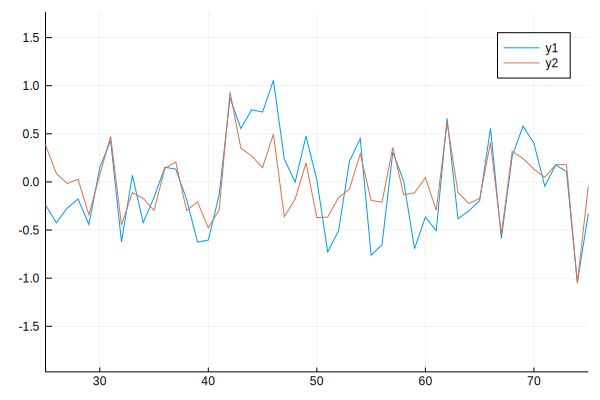

In [66]:
plot(data.-ou_data)
plot!(data.-mu_px)
plot!(xlims=(25,75))

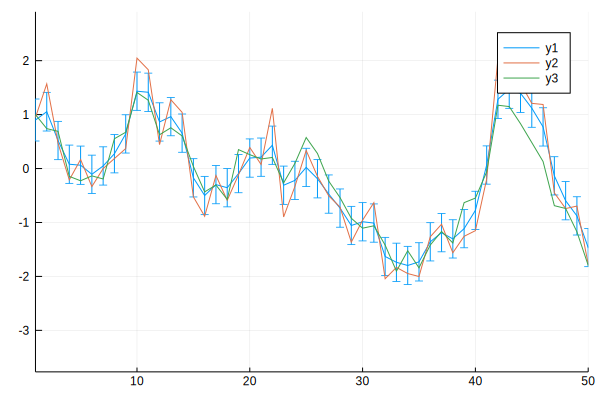

In [141]:
plot(mu_px,yerror=sig_px)
plot!(data)
plot!(ou_data)
plot!(xlims=(1,50))

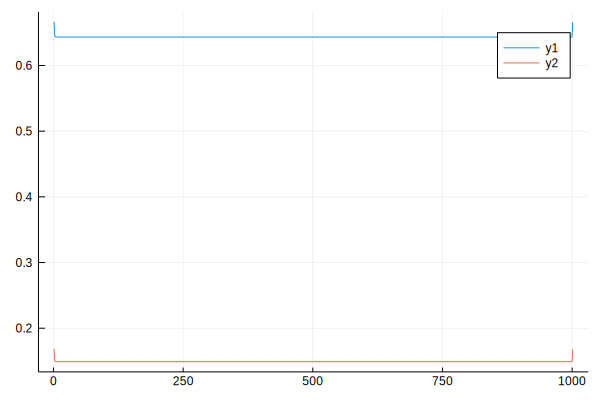

In [68]:
plot(rho)
plot!(exxpone)

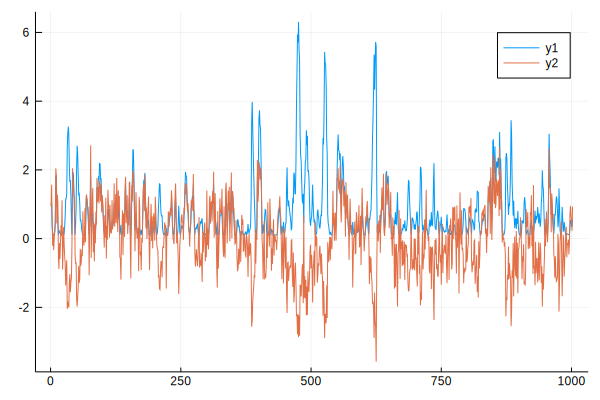

In [69]:
plot(exsq)
plot!(data)

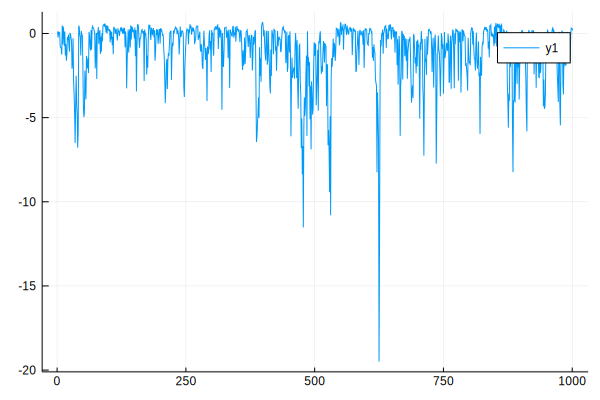

In [70]:
plot(exxxpone)

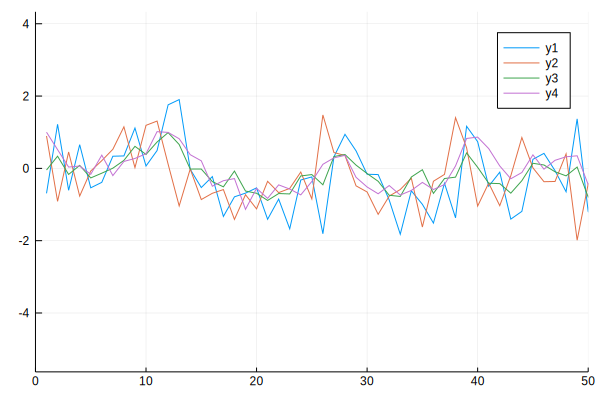

In [182]:
plot(mu_x)
plot!(mu_xpone)
plot!(mu_px)
plot!(ou_data)
plot!(xlims=(0,50))

In [86]:
sigmaNnew = sqrt(1/length(data)*sum(sig_px.^2+mu_px.^2+data.^2-2*mu_px.*data))

0.5436205352210381